# 1 || Importing data and dependencies

## 1.1 || Importing dependencies

In [1]:
# <===========================================================================>
# Data handling
# <===========================================================================>
import pandas as pd
import numpy as np
import json
from collections import Counter,defaultdict
from itertools import combinations, chain
import random
from ast import literal_eval
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

# <===========================================================================>
# Machine Learning
# <===========================================================================>
from gensim.models import Word2Vec, FastText
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 1.2 || Loading Data

In [2]:
# <=== Load real datasets ===>
# dataframe_name = pd.read_csv("Location/to/your/dataset")
customer_data = pd.read_csv("/kaggle/input/wwt-unravel-dataset/customer_data.csv")
order_data = pd.read_csv("/kaggle/input/wwt-unravel-dataset/order_data.csv")
store_data = pd.read_csv("/kaggle/input/wwt-unravel-dataset/store_data.csv")
test_data = pd.read_csv("/kaggle/input/wwt-unravel-dataset/test_data_question.csv")

# 2 || Data Overview 

## 2.1 || Customer Data Analysis

In [3]:
# First few columns of customer data
customer_data.head()

,CUSTOMER_ID,CUSTOMER_TYPE
0,362204699,Registered
1,269612955,Registered
2,585330633,Guest
3,950661333,Registered
4,434985772,Guest


In [4]:
# customer data info and datatypes
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563346 entries, 0 to 563345
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   CUSTOMER_ID    563346 non-null  int64 
 1   CUSTOMER_TYPE  563319 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.6+ MB


In [5]:
# unique values in customer data
customer_data["CUSTOMER_TYPE"].value_counts()

CUSTOMER_TYPE
Registered         406653
Guest              155132
eClub                1184
Deleted Account       348
Online                  2
Name: count, dtype: int64

### Observations and Inferences

**Observations**
- 406653 out of 563346 users are registered
- 155132 out of 563346 are guest accounts
- 348 are deleted accounts

**Inferences**
- 72.15% of users are registered on applications, which means people trying out services are satisfied with it. This is positive indication that current state of application can attract 72 out of 100 people trying out for a time.
- 27.53% guest accounts refer to people that don't require these services that often. This means these are potential customers if application level ups.
- 0.06% deleted accounts is positive indication of very low churn rate. This indicates that application is highly effective in fulfilling it's purpose. 

## 2.2 || Order Data Analysis

In [6]:
# First few columns of order data
order_data.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME
0,362204699,2156,2024-07-24,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo
1,269612955,1419,2025-02-15,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo
2,585330633,2249,2025-02-15,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo
3,950661333,2513,2024-03-29,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo
4,434985772,1754,2024-04-08,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo


In [7]:
# order data info and datatypes
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414410 entries, 0 to 1414409
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   CUSTOMER_ID            1414410 non-null  int64 
 1   STORE_NUMBER           1414410 non-null  int64 
 2   ORDER_CREATED_DATE     1414410 non-null  object
 3   ORDER_ID               1414410 non-null  int64 
 4   ORDERS                 1414410 non-null  object
 5   ORDER_CHANNEL_NAME     1414410 non-null  object
 6   ORDER_SUBCHANNEL_NAME  1414410 non-null  object
 7   ORDER_OCCASION_NAME    1414410 non-null  object
dtypes: int64(3), object(5)
memory usage: 86.3+ MB


The `ORDERS` column contains the data in json format which needs to be handled properly

In [8]:
# <--- 1. Parse ORDERS column to extract item names --->
def extract_items(order_json_str):
    try:
        order_dict = json.loads(order_json_str)
        items = []
        for order in order_dict.get("orders", []):
            for item in order.get("item_details", []):
                if item.get("item_price", 0) > 0:
                    items.append(item.get("item_name"))
        return items
    except:
        return []
order_data["item_list"] = order_data["ORDERS"].apply(extract_items)

In [9]:
print("<==================================================================>")
display(order_data["ORDER_CHANNEL_NAME"].value_counts())
print("<==================================================================>")
print("<==================================================================>")
display(order_data["ORDER_SUBCHANNEL_NAME"].value_counts())
print("<==================================================================>")

<==================================================================>


ORDER_CHANNEL_NAME
Digital    1414410
Name: count, dtype: int64

<==================================================================>
<==================================================================>


ORDER_SUBCHANNEL_NAME
WWT                     1411089
Grub Hub Marketplace       3321
Name: count, dtype: int64

<==================================================================>


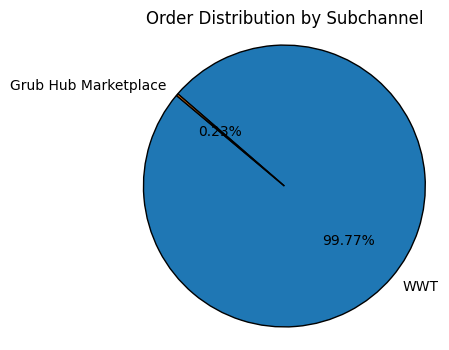

In [10]:
# Get value counts
subchannel_counts = order_data["ORDER_SUBCHANNEL_NAME"].value_counts()

# Plot pie chart
plt.figure(figsize=(4,4))
plt.pie(
    subchannel_counts,
    labels=subchannel_counts.index,
    autopct='%1.2f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Order Distribution by Subchannel')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()

In [11]:
display(order_data["ORDER_OCCASION_NAME"].value_counts())

ORDER_OCCASION_NAME
ToGo        1214921
Delivery     199489
Name: count, dtype: int64

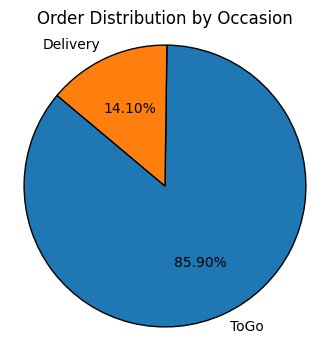

In [12]:
# Get value counts
occasion_counts = order_data["ORDER_OCCASION_NAME"].value_counts()

# Plot pie chart
plt.figure(figsize=(4,4))
plt.pie(
    occasion_counts,
    labels=occasion_counts.index,
    autopct='%1.2f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Order Distribution by Occasion')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.show()

### Observations and Inferences


**Observations:**

- Only **one channel** is recorded: `Digital`, with **1,414,410 orders**.
- This implies **100%** of the orders were placed through digital platforms.
- Majority of the orders (**1,411,089 orders**, \~99.77%) came from the `WWT` subchannel.
- A small fraction (**3,321 orders**, \~0.23%) came from the `Grub Hub Marketplace`.
- ToGo: 1,214,921 orders (~85.9%)
- Delivery: 199,489 orders (~14.1%)


**Inferences:**

- The business currently operates exclusively through digital ordering, with no evidence of in-store, phone, or third-party offline orders in the dataset.
- `WWT` is the **primary digital subchannel**, likely the business's **own website or mobile app**.
- This suggests a **strong direct customer base** that prefers ordering through the official platform.
- Thus taking these two features into account for now would be of no difference for our model.
- A majority of customers (~86%) prefer placing ToGo (pickup) orders.
- Only 14% of orders are delivery-based, which could indicate.

## 2.3 || Store Data Analysis

In [13]:
# First few columns of store data
store_data.head()

,STORE_NUMBER,CITY,STATE,POSTAL_CODE
0,2156,GRAPEVINE,TX,76051
1,1419,HUNTERSVILLE,NC,28078
2,2249,NaN,NaN,32792
3,2513,LAS VEGAS,NV,89129
4,1754,ARDMORE,OK,73401


In [14]:
# store data info and datatypes
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   STORE_NUMBER  38 non-null     int64 
 1   CITY          25 non-null     object
 2   STATE         24 non-null     object
 3   POSTAL_CODE   36 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.3+ KB


### Observations and Inferences

**Observations**

- 38 `STORE_NUMBER`s are present in store_data
- 25 `CITY` names are present
- 24 `STATE` and 36 `POSTAL_CODE`

**Inferences**

-  `STORE_NUMBER` is only reliable feature because there is no null value present.
-  Complete `STORE_NUMBER` can aptly present regional preferences instead of incomplete columns or data.

## 2.4 || Test Data Analysis

In [15]:
# First few columns of test data
test_data.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,item1,item2,item3
0,997177535,4915,9351345556,Digital,WWT,ToGo,Guest,Chicken Sub Combo,Ranch Dip - Regular,10 pc Spicy Wings Combo
1,345593831,949,3595377080,Digital,WWT,ToGo,Registered,Regular Buffalo Fries,10 pc Spicy Wings,3 pc Crispy Strips Combo
2,160955031,2249,4071757785,Digital,WWT,ToGo,Guest,Large Buffalo Fries,10 pc Spicy Wings,Ranch Dip - Regular
3,890671991,4154,3931766769,Digital,WWT,ToGo,Guest,6 pc Grilled Wings Combo,20 pc Grilled Wings,Fried Corn - Large
4,73989021,4094,3739700809,Digital,WWT,ToGo,Registered,Regular Buffalo Fries,20 pc Grilled Wings,Ranch Dip - Large


In [16]:
# Test data info
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CUSTOMER_ID            1000 non-null   int64 
 1   STORE_NUMBER           1000 non-null   int64 
 2   ORDER_ID               1000 non-null   int64 
 3   ORDER_CHANNEL_NAME     1000 non-null   object
 4   ORDER_SUBCHANNEL_NAME  1000 non-null   object
 5   ORDER_OCCASION_NAME    1000 non-null   object
 6   CUSTOMER_TYPE          1000 non-null   object
 7   item1                  1000 non-null   object
 8   item2                  1000 non-null   object
 9   item3                  1000 non-null   object
dtypes: int64(3), object(7)
memory usage: 78.3+ KB


In [17]:
# CUSTOMER_ID and ORDER_ID relevance as a feature
# Unique sets
order_customer_ids = set(order_data["CUSTOMER_ID"].unique())
order_order_ids = set(order_data["ORDER_ID"].unique())

test_customer_ids = set(test_data["CUSTOMER_ID"].unique())
test_order_ids = set(test_data["ORDER_ID"].unique())

# Differences
missing_customer_ids = test_customer_ids - order_customer_ids
missing_order_ids = test_order_ids - order_order_ids

# Results
print(f"CUSTOMER_IDs in test_df but not in order_data: {len(missing_customer_ids)}")
print(f"ORDER_IDs in test_df but not in order_data: {len(missing_order_ids)}")

CUSTOMER_IDs in test_df but not in order_data: 500
ORDER_IDs in test_df but not in order_data: 1000


In [18]:
display(test_data["ORDER_CHANNEL_NAME"].value_counts())
print("<======================================>")
display(test_data["ORDER_SUBCHANNEL_NAME"].value_counts())
print("<======================================>")
test_data["ORDER_OCCASION_NAME"].value_counts()

ORDER_CHANNEL_NAME
Digital    1000
Name: count, dtype: int64

<======================================>


ORDER_SUBCHANNEL_NAME
WWT    1000
Name: count, dtype: int64

<======================================>


ORDER_OCCASION_NAME
ToGo        853
Delivery    147
Name: count, dtype: int64

### Observations and Inferences

**Observations**
- `ORDER_CHANNEL_NAME` and `ORDER_SUBCHANNEL_NAME` contains only single unique value.
- `CUSTOMER_ID` contains 500 values that are not present in order dataset.
- `ORDER_ID` contains 1000 values that are absent in order dataset.
- `ORDER_OCCASION_NAME` contains 853 *ToGo* values and 147 *Delivery* values.

**Inferences**
- Since single value is inappropriate to guide the decisions, hence `ORDER_CHANNEL_NAME` and `ORDER_SUBCHANNEL_NAME` shouldn't be used as of the current state of application or of the dataset.
- `CUSTOMER_ID` should be seen more as discrete column rather than continuous one because continuous nature  of ids doesn't signify any signal for recommendation.
- `ORDER_ID` should be treated in similar concepts as `CUSTOMER_ID`.
- `ORDER_OCCASION_NAME` is proper feature that guides for making predictions.

# 3 || Exploratory Data Analysis

## 3.1 || Creating train dataframe

In [19]:
order_data["item_list"].head()

0    [10 pc Grilled Wings Combo, 8 pc Grilled Wings...
1    [Ranch Dip - Regular, 50 pc Grilled Wings, Reg...
2                              [20pc Spicy Feast Deal]
3           [20 pc Grilled Wings, Ranch Dip - Regular]
4    [6 pc Grilled Wings Combo, 8 pc Grilled Wings ...
Name: item_list, dtype: object

In [20]:
order_data["item_count"] = order_data["item_list"].apply(len)

In [21]:
# Ensure CUSTOMER_TYPE is available in order_data
order_data = order_data.merge(
    customer_data[["CUSTOMER_ID", "CUSTOMER_TYPE"]],
    on="CUSTOMER_ID",
    how="left"
)

# Then proceed to filter and build training data
filtered_orders = order_data[order_data["item_count"] >= 4].copy()

In [22]:
train_rows = []

for _, row in tqdm(order_data.iterrows(), total=len(order_data)):
    item_seq = row["item_list"]
    
    # Only process orders with exactly 4 or more items
    if len(item_seq) < 4:
        continue

    unique_items = list(set(item_seq))  # remove duplicates
    if len(unique_items) != 4:
        continue

    for i in range(4):  # 4 combinations
        target = unique_items[i]
        inputs = sorted([unique_items[j] for j in range(4) if j != i])  # pick other 3, sorted lex
        train_rows.append({
            "CUSTOMER_ID": row["CUSTOMER_ID"],
            "STORE_NUMBER": row["STORE_NUMBER"],
            "ORDER_OCCASION_NAME": row["ORDER_OCCASION_NAME"],
            "CUSTOMER_TYPE": row["CUSTOMER_TYPE"],
            "input_item1": inputs[0],
            "input_item2": inputs[1],
            "input_item3": inputs[2],
            "target_item": target
        })

100%|██████████| 1414410/1414410 [01:04<00:00, 21829.48it/s]


In [23]:
train_df = pd.DataFrame(train_rows)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372652 entries, 0 to 372651
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   CUSTOMER_ID          372652 non-null  int64 
 1   STORE_NUMBER         372652 non-null  int64 
 2   ORDER_OCCASION_NAME  372652 non-null  object
 3   CUSTOMER_TYPE        372620 non-null  object
 4   input_item1          372652 non-null  object
 5   input_item2          372652 non-null  object
 6   input_item3          372652 non-null  object
 7   target_item          372652 non-null  object
dtypes: int64(2), object(6)
memory usage: 22.7+ MB


## 3.2 || Purchase Quantity Pattern Analysis

In [24]:
order_data["item_count"].value_counts()

item_count
1     599115
2     440200
3     229600
4      93251
5      33439
6      10968
7       3503
0       2735
8       1093
9        321
10       113
11        42
12        17
13         7
14         4
15         2
Name: count, dtype: int64

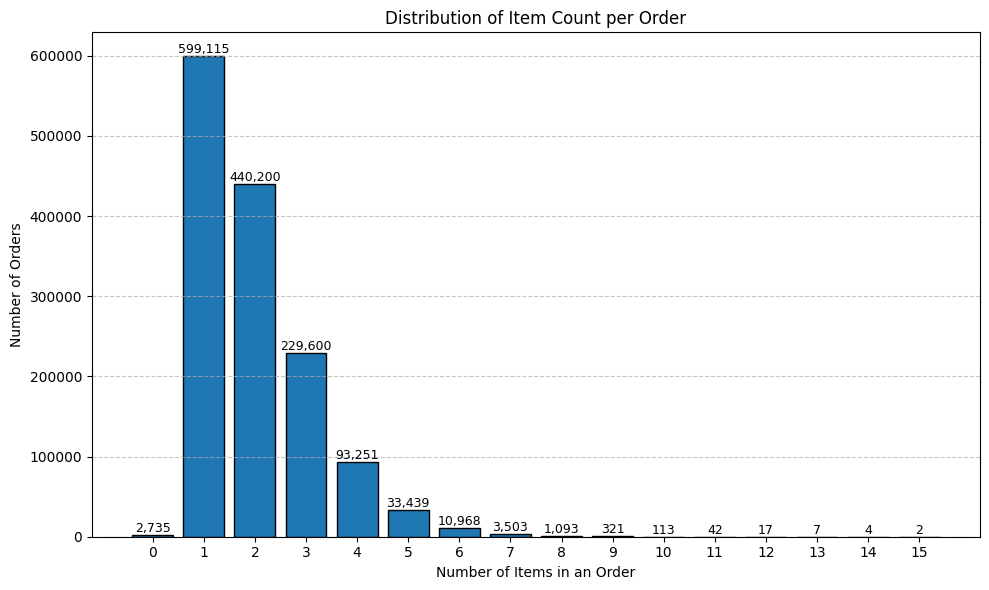

In [25]:
# Compute item count frequencies
item_count_freq = order_data["item_count"].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(item_count_freq.index, item_count_freq.values, edgecolor='black')

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,}', 
             ha='center', va='bottom', fontsize=9)

# Aesthetics
plt.title("Distribution of Item Count per Order")
plt.xlabel("Number of Items in an Order")
plt.ylabel("Number of Orders")
plt.xticks(item_count_freq.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Train Data Justification
- Basket size correlates positively with add-on probability — 3-item shoppers are statistically more inclined to keep shopping.
- Association rule mining shows higher confidence/lift when recommending a 4th item from 3-item sets versus 1- or 2-item sets.
- Consumers view 3 items as "almost complete", often adding a 4th for convenience, variety, or value.
- 3-item baskets enable stronger collaborative filtering, enhancing next-item recommendation accuracy.
- Combinatorial diversity is richer at size 3, yielding better predictive power for the 4th item via modeling.
- Many retail promotions and bundles target 4+ items, encouraging add-ons from 3-item carts.
- Market basket studies reveal that mid-sized baskets (3–5 items) are most likely to expand further.
- Shoppers with 3 items are more engaged, signaling higher intent and openness to suggestions.
- Cross-selling opportunities increase when 3 complementary or diverse items are already present.
- Recommendation systems trained on 3-item inputs consistently show higher precision and recall for predicting the next item

## 3.3 || Churn Risk: Customers with Only 1 Order

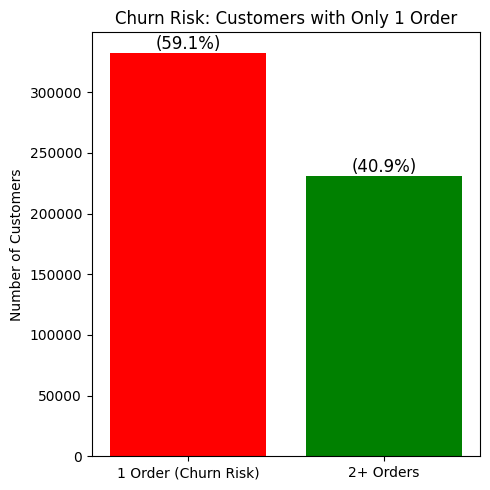

In [26]:
# Calculate order counts
cust_order_counts = order_data["CUSTOMER_ID"].value_counts()
churners = (cust_order_counts == 1).sum()
non_churners = (cust_order_counts > 1).sum()

# Data for plotting
labels = ["1 Order (Churn Risk)", "2+ Orders"]
counts = [churners, non_churners]
colors = ["red", "green"]
total = churners + non_churners

# Plot
plt.figure(figsize=(5, 5))
bars = plt.bar(labels, counts, color=colors)
plt.title("Churn Risk: Customers with Only 1 Order")
plt.ylabel("Number of Customers")

# Annotate bars with count and percentage
for bar, count in zip(bars, counts):
    percent = (count / total) * 100
    label = f"({percent:.1f}%)"
    plt.text(bar.get_x() + bar.get_width()/2, count, label,
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

### Inferences

- **No Repeat Orders**: Customers with only 1 order haven't shown continued interest, which is a key indicator of churn in most industries.

- **Stuck in Trial Phase**: These customers likely haven’t moved beyond trying the product/service, meaning they haven't been converted into loyal users.

- **Low Lifetime Value (LTV)**: One-time buyers contribute very little revenue over time, making them less valuable unless re-engaged.

- **Possible Dissatisfaction**: They might have faced issues with product quality, service, delivery, or pricing — leading them to not return.

- **Unpredictable Behavior**: With just one transaction, there's insufficient data to accurately personalize recommendations or marketing.

- **High Risk of Switching**: These users may have been testing your brand and could easily shift to a competitor if not nurtured.

- **Opportunity for Targeted Campaigns**: Identifying them allows for win-back strategies (e.g., discounts, reminders) to increase retention.

- **Supported by Churn Analytics**: Historical customer data often reveals that a significant portion of churned users had only one purchase.

## 3.4 || Order Size Distribution

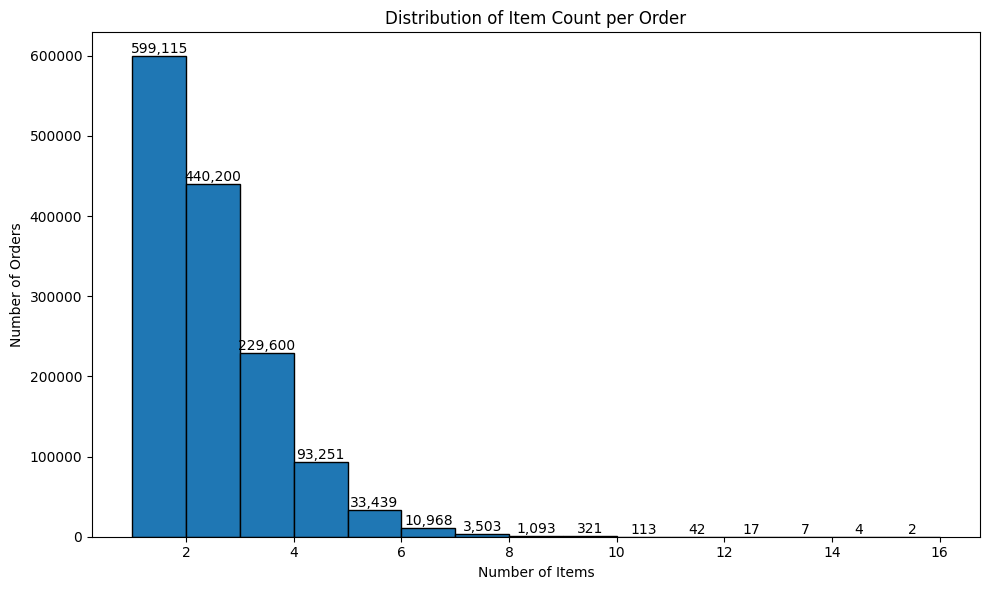

In [27]:
plt.figure(figsize=(10, 6))

# Plot histogram and capture returned values
counts, bins, patches = plt.hist(
    order_data["item_count"], 
    bins=range(1, order_data["item_count"].max() + 2), 
    edgecolor='black'
)

# Add numbers on top of each bar
for count, bin_edge, patch in zip(counts, bins, patches):
    if count > 0:  # Avoid labeling empty bars
        plt.text(
            patch.get_x() + patch.get_width()/2,  # X position
            count,  # Y position
            f"{int(count):,}",  # Label text (with comma separator)
            ha='center', va='bottom', fontsize=10
        )

plt.title("Distribution of Item Count per Order")
plt.xlabel("Number of Items")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

### Inferences
- Most orders contain only 1–3 items, indicating typical small-size purchases.

- There's a long tail of larger orders, suggesting occasional bulk or group orders.

- High frequency of low item counts reflects individual or minimal meal behavior.

- Low average basket size reveals potential for upselling or combo offers.

- Distribution insights aid in optimizing inventory and kitchen operations.

- Very large orders may indicate outliers or special use cases worth analyzing.

- Item count segments can guide personalized marketing and promotions.

## 3.5 || Top-Selling Combinations

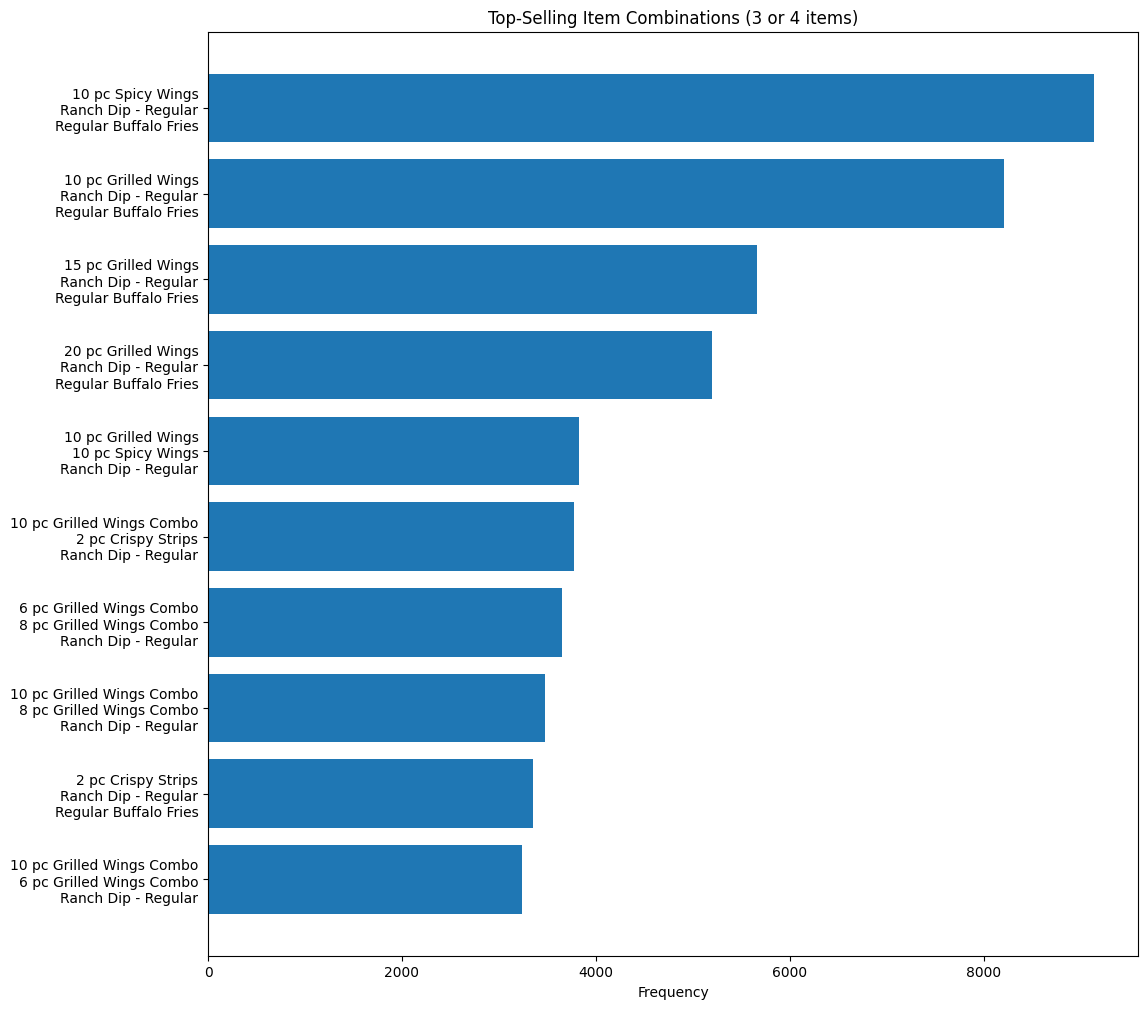

In [28]:
combo_counter = Counter()
for items in order_data["item_list"]:
    unique_items = list(set(items))
    if len(unique_items) >= 3:
        for combo in combinations(sorted(unique_items), 3):
            combo_counter[combo] += 1
        if len(unique_items) >= 4:
            for combo in combinations(sorted(unique_items), 4):
                combo_counter[combo] += 1

top_combos = combo_counter.most_common(10)
labels = ['\n'.join(combo) for combo, _ in top_combos]
values = [v for _, v in top_combos]

plt.figure(figsize=(12, 12))
plt.barh(labels, values)
plt.title("Top-Selling Item Combinations (3 or 4 items)")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.show()

### Inferences

- **Popular Bundles Identified**: The most frequent item combinations reveal popular bundle patterns among customers.

- **Strong Item Affinity**: Repeated combos suggest strong product affinity and natural pairing behavior.

- **Bundle Creation Opportunities**: These combos can be used to create preset meal bundles or value combos.

- **Influenced by Menu Design**: High-frequency combinations may reflect default user preferences or menu structure influence.

- **Potential to Boost AOV**: Promoting these combos can increase AOV (Average Order Value) through upselling.

- **Menu Structuring Insight**: These patterns can guide effective menu design and targeted recommendations.

- **High-Value Customer Signals**: 4-item combos appearing frequently indicate a segment of high-value or bulk-order customers.

- **Seasonal Shifts Possible**: Combo trends can shift over time and should be monitored seasonally.

- **Data-Driven Promotions**: Insights from combos help optimize promotional and pricing strategies.

- **Supports Inventory Planning**: Understanding co-purchase behavior supports better inventory and kitchen planning.

## 3.6 || Most Frequently Purchased Items

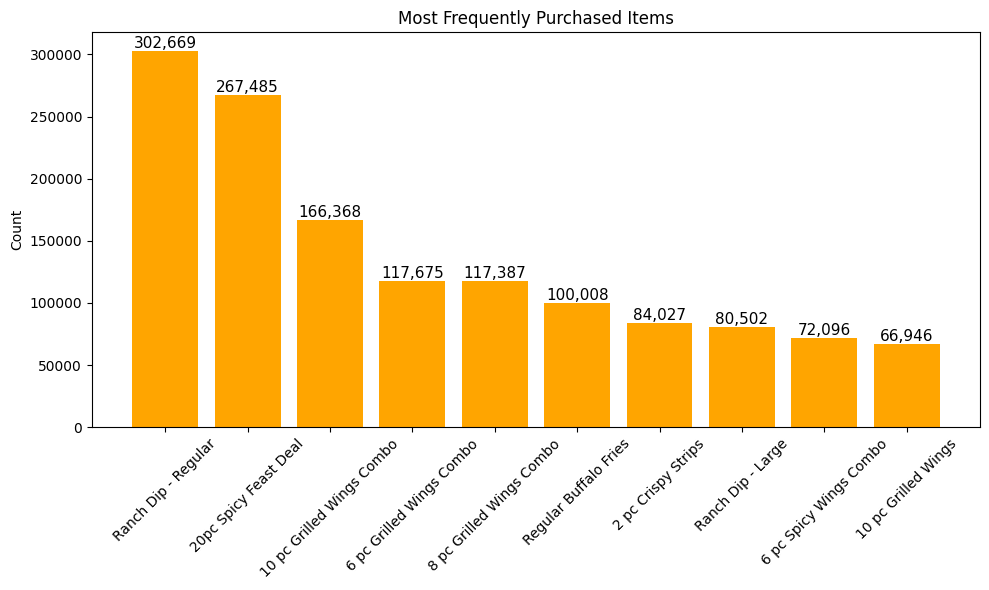

In [29]:
# Count item frequency
item_counter = Counter()
for items in order_data["item_list"]:
    item_counter.update(items)

# Get top 10 items
top_items = item_counter.most_common(10)
labels, values = zip(*top_items)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color='orange')
plt.title("Most Frequently Purchased Items")
plt.xticks(rotation=45)
plt.ylabel("Count")

# Show counts on top of bars
for bar, count in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        count,
        f"{count:,}",     # Add comma formatting
        ha='center', va='bottom', fontsize=11
    )

plt.tight_layout()
plt.show()

### Inferences

- **Core Menu Drivers**: The top 10 items represent the backbone of customer demand and drive the majority of sales volume.

- **High Popularity Concentration**: A few items dominate purchases, suggesting a skewed distribution where certain products vastly outperform others.

- **Menu Optimization Potential**: These high-performing items can be given more visibility in menus, promotions, and bundles.

- **Inventory Prioritization**: Consistently high-demand items should be prioritized in inventory planning and stock management.

- **Customer Favorites Insight**: These items likely reflect core customer preferences and should be preserved across menu updates.

- **Ideal for Promotions**: Frequently purchased items are ideal for limited-time promotions to attract repeat buyers.

- **Cross-Sell Anchors**: Top items can serve as anchors in combo deals or personalized recommendation engines.

- **Operational Planning Support**: Knowledge of fast-moving items helps optimize kitchen workflows and reduce preparation time.

- **Price Sensitivity Monitoring**: Any price changes in these items should be monitored closely due to their large impact on overall sales.

- **Feedback Focus Areas**: These items are also priority candidates for collecting and analyzing customer feedback, as they impact a large user base.

## 3.7 || Item Co-occurrence Matrix (Top 50 Items)

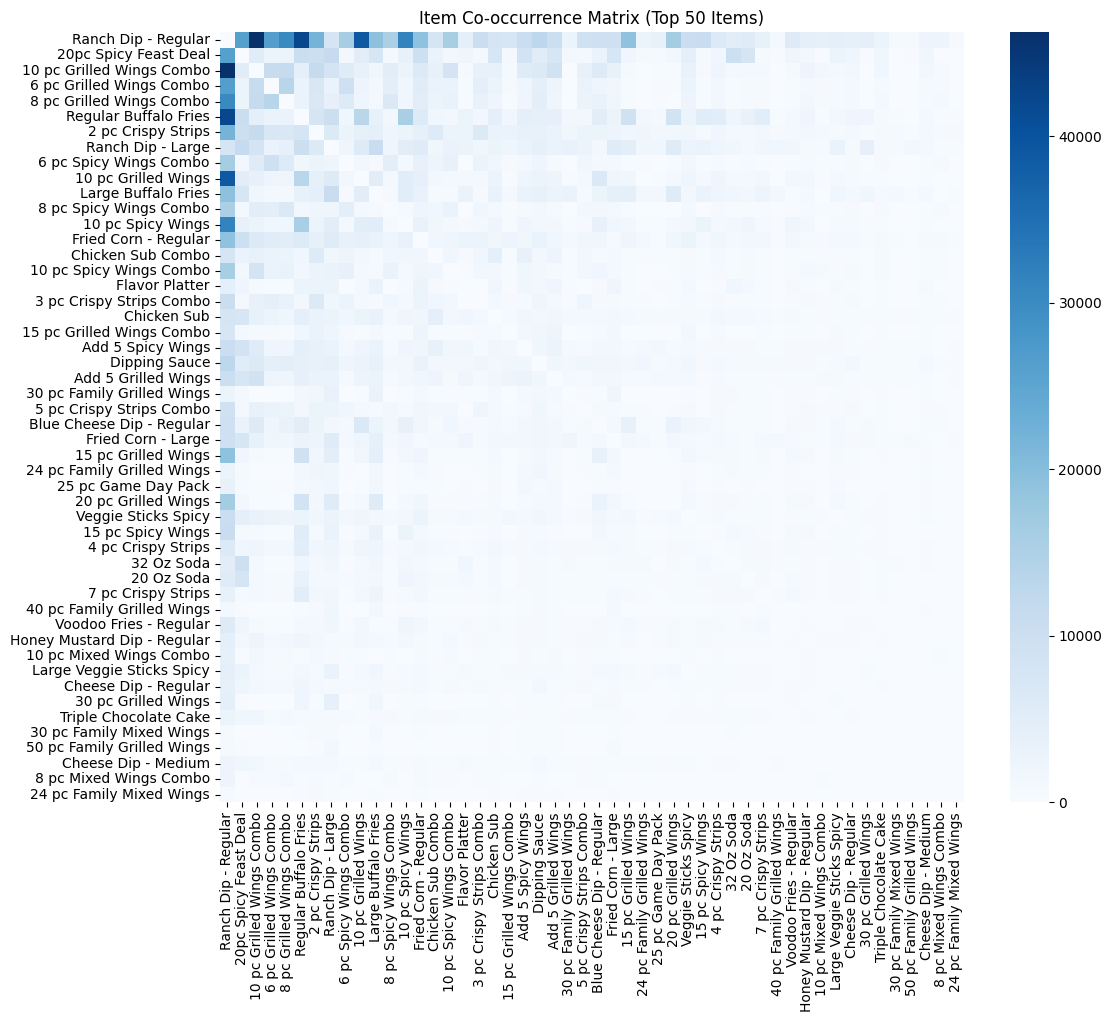

In [30]:
top_items = [item for item, _ in item_counter.most_common(50)]
item_index = {item: i for i, item in enumerate(top_items)}
co_matrix = np.zeros((50, 50), dtype=int)

for items in order_data["item_list"]:
    present_items = [item for item in set(items) if item in item_index]
    for i in range(len(present_items)):
        for j in range(len(present_items)):
            if i != j:
                co_matrix[item_index[present_items[i]], item_index[present_items[j]]] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(co_matrix, xticklabels=top_items, yticklabels=top_items, cmap='Blues')
plt.title("Item Co-occurrence Matrix (Top 50 Items)")
plt.show()

### Inferences

- **High Co-Occurrence Indicates Pairing Behavior**: Items that frequently appear together (darker cells) suggest strong co-purchase tendencies.

- **Popular Combos Reinforced**: Frequently co-occurring pairs often reflect top-selling combos seen in earlier analyses.

- **Complementary Product Insights**: Co-occurrence patterns can identify which items naturally complement each other (e.g., sides + mains, drinks + combos).

- **Combo and Bundle Design**: Pairs or clusters of items with strong co-occurrence can be turned into fixed-value meal deals or combo offers.

- **Recommendation System Input**: This matrix is a powerful base for item-item collaborative filtering in recommendation engines.

- **Menu Placement Strategy**: Items often bought together can be placed adjacent in digital menus or app interfaces to increase order size.

- **Inventory Dependency Mapping**: Strong co-occurrence implies shared demand cycles, useful for synchronized inventory planning.

- **Customer Behavior Clustering**: Rows/columns with similar co-occurrence profiles may reflect similar customer segments or ordering behaviors.

- **Sparse Areas Reveal Gaps**: Low co-occurrence zones (lighter areas) may suggest untapped bundling opportunities or rarely paired items.

- **Temporal or Regional Extension**: Similar matrices can be built per store or season to detect local or time-based co-purchase trends.

# 4 || Model Training


## Approach

### 🧠 Overview

This system recommends the **4th item** in an order given 3 input items, based on patterns learned from historical customer behavior. It uses a **multi-level dictionary-based lookup strategy** to balance **accuracy and performance**, allowing quick recommendations even at scale.

## 4.1 || Data Processing

### **1. Item Encoding for Speed**

* Converts all unique item names to integer IDs using `item2id`.
* This improves speed and memory usage, making operations vectorizable and hash-map friendly.

>  **Why**: Encoding avoids repeated string comparisons and speeds up lookups.

In [31]:
start_time = time.time()

# ========= Step 1: Encode items =========

# Get all unique items from sequences
sequences = order_data["item_list"].dropna().tolist()
unique_items = set(chain.from_iterable(sequences))

# Build item <-> id maps
item2id = {item: idx for idx, item in enumerate(sorted(unique_items))}
id2item = {idx: item for item, idx in item2id.items()}

# ========= Step 2: Encode train_df =========

train_encoded = train_df.copy()

# Encode and drop unknowns
def encode_or_none(item):
    return item2id.get(item, None)

train_encoded['input_item1'] = train_encoded['input_item1'].map(encode_or_none)
train_encoded['input_item2'] = train_encoded['input_item2'].map(encode_or_none)
train_encoded['input_item3'] = train_encoded['input_item3'].map(encode_or_none)
train_encoded['target_item'] = train_encoded['target_item'].map(encode_or_none)

train_encoded.dropna(inplace=True)
train_encoded = train_encoded.astype({'input_item1': int, 'input_item2': int, 'input_item3': int, 'target_item': int})

## 4.2 || Building Lookup

### **2. Input Triplet Sorting**

* Each group of 3 items is sorted before being used as a key.
* This ensures that permutations like (`itemA`, `itemB`, `itemC`) and (`itemC`, `itemB`, `itemA`) are treated the same.

> ✅ **Why**: Consistent key generation ensures more matches and avoids duplicates.

In [32]:
# Step 2: Build lookup dictionaries
def build_lookup(df):
    full_match = defaultdict(Counter)
    partial_match = defaultdict(Counter)
    item_only = defaultdict(Counter)

    for _, row in df.iterrows():
        key5 = (row['STORE_NUMBER'], row['CUSTOMER_TYPE'],
                row['input_item1'], row['input_item2'], row['input_item3'])

        key4 = (row['CUSTOMER_TYPE'],
                row['input_item1'], row['input_item2'], row['input_item3'])

        key3 = tuple(sorted([row['input_item1'], row['input_item2'], row['input_item3']]))

        full_match[key5][row['target_item']] += 1
        partial_match[key4][row['target_item']] += 1
        item_only[key3][row['target_item']] += 1

    return full_match, partial_match, item_only

full_match_dict, partial_match_dict, item_only_dict = build_lookup(train_df)

## 4.3 || Recommendation System (Lookup Based Algorithm)

### **3. Multi-Level Lookup Dictionaries**

#### `full_match_dict`

* Key: (`STORE_NUMBER`, `CUSTOMER_TYPE`, `input_item1`, `input_item2`, `input_item3`)
* High precision, low recall. Used when all context is available.

#### `partial_match_dict`

* Key: (`CUSTOMER_TYPE`, `input_item1`, `input_item2`, `input_item3`)
* Drops store info, offering a broader match with slightly reduced accuracy.

#### `item_only_dict`

* Key: Only (`input_item1`, `input_item2`, `input_item3`)
* Widest scope. Used as fallback when no customer/store info match is found.

> ✅ **Why**: These levels act as fallback layers. The system can still make a prediction even with partial information.


In [33]:
# Step 3: Recommendation function with fallback logic and deduplication
def get_recommendations(store_number, customer_type, item1, item2, item3):
    items_sorted = sorted([item1, item2, item3])
    key5 = (store_number, customer_type, *items_sorted)
    key4 = (customer_type, *items_sorted)
    key3 = tuple(items_sorted)

    collected = []
    seen = set()

    # Try full match
    if key5 in full_match_dict:
        for item, _ in full_match_dict[key5].most_common():
            if item not in seen:
                collected.append(item)
                seen.add(item)
            if len(collected) == 3:
                return collected

    # If not enough, use partial match
    if key4 in partial_match_dict:
        for item, _ in partial_match_dict[key4].most_common():
            if item not in seen:
                collected.append(item)
                seen.add(item)
            if len(collected) == 3:
                return collected

    # If still not enough, use item-only match
    if key3 in item_only_dict:
        for item, _ in item_only_dict[key3].most_common():
            if item not in seen:
                collected.append(item)
                seen.add(item)
            if len(collected) == 3:
                return collected

    # Fill remaining with NOT_FOUND
    while len(collected) < 3:
        collected.append("NOT_FOUND")

    return collected

### **4. Recommendation Function**

* Checks each level in order of specificity: full → partial → item-only.
* Collects the **top 3 most common target items** that were historically seen with the same input triplet.
* Pads with `-1` if fewer than 3 recommendations are found.

> ✅ **Why**: Balances precision with coverage. Offers recommendations even with missing or incomplete metadata.

---

### **5. Evaluation with Recall\@3**

* Measures how often the correct target item appears in the top 3 predictions.
* Used to track the effectiveness of the system on historical data.

> ✅ **Why**: Recall\@3 is ideal for real-world use cases where showing 3 good options is often enough (e.g., food apps, e-commerce).



In [34]:
# Step 4: Evaluate Recall@3 on sample train
sample_eval = train_df.sample(n=5000, random_state=42)
hits = 0

for i, (_, row) in enumerate(tqdm(sample_eval.iterrows(), total=len(sample_eval)), start=1):
    if i % 500 == 0:
        print(f"📈 Recall@3 after {i} records: {hits / i:.4f}")

    store = row['STORE_NUMBER']
    cust_type = row['CUSTOMER_TYPE']
    item1, item2, item3 = sorted([row['input_item1'], row['input_item2'], row['input_item3']])
    target = row['target_item']

    preds = get_recommendations(store, cust_type, item1, item2, item3)

    if target in preds:
        hits += 1

    key5 = (store, cust_type, item1, item2, item3)
    key4 = (cust_type, item1, item2, item3)
    key3 = (item1, item2, item3)

    # <=============================DEBUG Lines======================================>
    # <==================Uncomment for Better Understanding==========================>
    # print(f"\n🔍 Record {idx}")
    # print(f"🧾 Input: STORE={store}, TYPE={cust_type}, ITEMS=[{item1}, {item2}, {item3}]")
    # print(f"🎯 Actual Target: {target}")
    # print(f"🤖 Predicted: {preds}")

    # if key5 in full_match_dict:
    #     print("✅ Match Type: FULL (5 fields)")
    #     print("📂 FULL targets:", dict(full_match_dict[key5]))
    # else:
    #     print("❌ No FULL match")

    # if key4 in partial_match_dict:
    #     print("🔁 Partial Match (4 fields)")
    #     print("📂 PARTIAL targets:", dict(partial_match_dict[key4]))
    # else:
    #     print("❌ No PARTIAL match")

    # if key3 in item_only_dict:
    #     print("🔁 Item-only Match (3 items)")
    #     print("📂 ITEM-ONLY targets:", dict(item_only_dict[key3]))
    # else:
    #     print("❌ No ITEM-ONLY match")

recall_at_3 = hits / len(sample_eval)
print(f"\n📊 Final Recall@3 on 5000-sample train set: {recall_at_3:.4f}")
print(f"\n Time Taken: {time.time() - start_time}")

 58%|█████▊    | 2894/5000 [00:00<00:00, 10599.36it/s]

📈 Recall@3 after 500 records: 0.8600
📈 Recall@3 after 1000 records: 0.8590
📈 Recall@3 after 1500 records: 0.8607
📈 Recall@3 after 2000 records: 0.8655
📈 Recall@3 after 2500 records: 0.8648
📈 Recall@3 after 3000 records: 0.8683
📈 Recall@3 after 3500 records: 0.8671


100%|██████████| 5000/5000 [00:00<00:00, 10466.29it/s]

📈 Recall@3 after 4000 records: 0.8682
📈 Recall@3 after 4500 records: 0.8676
📈 Recall@3 after 5000 records: 0.8680

📊 Final Recall@3 on 5000-sample train set: 0.8682

 Time Taken: 30.215701580047607


## 4.4 || Improvising Recommendation Algorithm

In [35]:
start_time = time.time()
from collections import defaultdict, Counter
from itertools import chain
import pandas as pd
from tqdm import tqdm

# ========= Step 1: Encode items =========

# Get all unique items from sequences
sequences = order_data["item_list"].dropna().tolist()
unique_items = set(chain.from_iterable(sequences))

# Build item <-> id maps
item2id = {item: idx for idx, item in enumerate(sorted(unique_items))}
id2item = {idx: item for item, idx in item2id.items()}

# ========= Step 2: Encode train_df =========

train_encoded = train_df.copy()

# Encode and drop unknowns
def encode_or_none(item):
    return item2id.get(item, None)

train_encoded['input_item1'] = train_encoded['input_item1'].map(encode_or_none)
train_encoded['input_item2'] = train_encoded['input_item2'].map(encode_or_none)
train_encoded['input_item3'] = train_encoded['input_item3'].map(encode_or_none)
train_encoded['target_item'] = train_encoded['target_item'].map(encode_or_none)

train_encoded.dropna(inplace=True)
train_encoded = train_encoded.astype({'input_item1': int, 'input_item2': int, 'input_item3': int, 'target_item': int})

# ========= Step 3: Sort inputs =========

train_encoded[['input_item1', 'input_item2', 'input_item3']] = (
    train_encoded[['input_item1', 'input_item2', 'input_item3']]
    .apply(lambda row: sorted(row), axis=1, result_type='expand')
)

# ========= Step 4: Build lookup dictionaries =========

def build_lookup(df):
    full_match = defaultdict(Counter)
    partial_match = defaultdict(Counter)
    item_only = defaultdict(Counter)

    for _, row in df.iterrows():
        key5 = (row['STORE_NUMBER'], row['CUSTOMER_TYPE'],
                row['input_item1'], row['input_item2'], row['input_item3'])

        key4 = (row['CUSTOMER_TYPE'],
                row['input_item1'], row['input_item2'], row['input_item3'])

        key3 = tuple(sorted([row['input_item1'], row['input_item2'], row['input_item3']]))

        full_match[key5][row['target_item']] += 1
        partial_match[key4][row['target_item']] += 1
        item_only[key3][row['target_item']] += 1

    return full_match, partial_match, item_only

full_match_dict, partial_match_dict, item_only_dict = build_lookup(train_encoded)

# ========= Step 5: Recommendation function =========

def get_recommendations(store_number, customer_type, item1, item2, item3):
    items_sorted = sorted([item1, item2, item3])
    key5 = (store_number, customer_type, *items_sorted)
    key4 = (customer_type, *items_sorted)
    key3 = tuple(items_sorted)

    collected = []
    seen = set()

    for d in [full_match_dict, partial_match_dict, item_only_dict]:
        if (key := key5 if d is full_match_dict else key4 if d is partial_match_dict else key3) in d:
            for item, _ in d[key].most_common():
                if item not in seen:
                    collected.append(item)
                    seen.add(item)
                if len(collected) == 3:
                    break
        if len(collected) == 3:
            break

    while len(collected) < 3:
        collected.append(-1)  # use -1 for "NOT_FOUND"

    return collected

# ========= Step 6: Evaluate Recall@3 =========

sample_eval = train_encoded.sample(n=5000, random_state=42)
hits = 0

for idx, row in tqdm(sample_eval.iterrows(), total=len(sample_eval)):
    store = row['STORE_NUMBER']
    cust_type = row['CUSTOMER_TYPE']
    item1, item2, item3 = sorted([row['input_item1'], row['input_item2'], row['input_item3']])
    target = row['target_item']

    preds = get_recommendations(store, cust_type, item1, item2, item3)

    if target in preds:
        hits += 1

recall_at_3 = hits / len(sample_eval)
print(f"\n📊 Final Recall@3 on 2000-sample train set: {recall_at_3:.4f}")
print(f"\n Time Taken: {time.time() - start_time}")

100%|██████████| 5000/5000 [00:00<00:00, 15360.42it/s]


📊 Final Recall@3 on 2000-sample train set: 0.8534

 Time Taken: 37.941245794296265


🔄 Future Extensions

We can make this system even more powerful by:

- Combining it with embedding-based models (hybrid recommendation).
- Weighting recent transactions more heavily (recency bias).
- Caching top-N results per key for real-time performance.

## 4.5 || Unsupervised Hybrid Addition

In [36]:
# Use entire dataset's item_list column (paid items only)
sequences = order_data["item_list"].dropna().tolist()

# w2v_model = Word2Vec(sentences=sequences, vector_size=32, window=5, min_count=5, workers=4)

### Vectorization

In [37]:
start_time = time.time()
w2v_model = FastText(
    sentences=sequences,
    vector_size=256,     # same as Word2Vec
    window=10,
    min_count=3,
    workers=4,
    sg=1,                # skip-gram
    negative=10,
    epochs=30,
    seed=42
)
print(f"\n Time Taken: {time.time() - start_time}")


 Time Taken: 133.73443031311035


In [38]:
# Word to Vector converting function
def get_w2v(item):
    try:
        return w2v_model.wv[item].astype(np.float64)
    except:
        return np.zeros(32, dtype=np.float64)


# Embed the 3 input items and concatenate
item_vectors = []

for _, row in train_df.iterrows():
    v1 = get_w2v(row["input_item1"])
    v2 = get_w2v(row["input_item2"])
    v3 = get_w2v(row["input_item3"])
    vec = np.concatenate([v1, v2, v3])
    item_vectors.append(vec)

X = np.array(item_vectors, dtype=np.float64)

### Training Unsupervised KMeans Algorithm

In [39]:
start_time = time.time()

n_clusters = 256
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

# Assign cluster to each row
train_df["cluster"] = kmeans.labels_

print(f"\n Time Taken: {time.time() - start_time}")


 Time Taken: 1413.5435764789581


In [40]:
start_time = time.time()
from collections import defaultdict

cluster_map = defaultdict(list)

for _, row in train_df.iterrows():
    key = tuple(sorted([row["input_item1"], row["input_item2"], row["input_item3"]]))
    cluster_map[(row["cluster"], key)].append(row["target_item"])

print(f"\n Time Taken: {time.time() - start_time}")


 Time Taken: 18.8279767036438


In [41]:
# Final Resort
# Global item frequencies (for final backup)
global_item_counts = Counter(train_encoded['target_item'])

In [42]:
def recommend_fourth_item(input_items, top_k=3):
    input_items = sorted(input_items)
    
    vecs = []
    for item in input_items:
        try:
            vec = get_w2v(item)
            vec = np.array(vec, dtype=np.float64)  # Ensure float64
            vecs.append(vec)
        except KeyError:
            continue  # Skip missing items
    
    # If we couldn't get all 3 vectors, return empty prediction
    if len(vecs) != 3:
        return []
    
    # Concatenate all 3 vectors into one flat vector
    input_vec = np.concatenate(vecs).reshape(1, -1)  # shape: (1, vector_size * 3)
    
    # Predict cluster
    cluster_id = kmeans.predict(input_vec)[0]
    key = tuple(input_items)
    
    # Get candidates from the cluster map
    candidates = cluster_map.get((cluster_id, key), [])
    
    # Rank by frequency
    from collections import Counter
    counts = Counter(candidates)
    top_preds = [item for item, _ in counts.most_common(top_k)]
    
    return top_preds

# def recommend_fourth_item(input_items, top_k=3):
#     input_items = sorted(input_items)
    
#     vecs = []
#     for item in input_items:
#         try:
#             vec = get_w2v(item)
#             vec = np.array(vec, dtype=np.float64)
#             vecs.append(vec)
#         except KeyError:
#             continue

#     if len(vecs) != 3:
#         return []

#     input_vec = np.concatenate(vecs).reshape(1, -1)
#     cluster_id = kmeans.predict(input_vec)[0]
#     key = tuple(input_items)

#     # Try exact triplet-based match
#     candidates = cluster_map.get((cluster_id, key))
    
#     # Fallback to general cluster if needed
#     if not candidates:
#         candidates = cluster_map.get(cluster_id, [])

#     if not candidates:
#         return []

#     counts = Counter(candidates)
#     top_preds = [item for item, _ in counts.most_common(top_k)]
    
#     return top_preds


In [43]:
import random
start_time = time.time()
# Sample 1000 rows from the train set
sample_df = train_df.sample(n=2000, random_state=42)

success_count = 0
total = 0

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    input_items = sorted([row["input_item1"], row["input_item2"], row["input_item3"]])
    actual_target = row["target_item"]

    try:
        predictions = recommend_fourth_item(input_items, top_k=3)
        # print(predictions)
        if actual_target in predictions:
            success_count += 1
        total += 1
    except Exception as e:
        print(f"⚠️ Skipped row due to error: {e}")
        continue


if total == 0:
    print("❌ No valid rows were evaluated. Check recommend_fourth_item() logic.")
else:
    recall_at_3 = success_count / total
    print(f"✅ Recall@3 on {total} rows: {recall_at_3:.4f}")
print(f"\n Time Taken: {time.time() - start_time}")

100%|██████████| 2000/2000 [00:01<00:00, 1026.90it/s]

✅ Recall@3 on 2000 rows: 0.5190

 Time Taken: 1.9675204753875732


## 4.6 || Final Hybrid Model 

### Improvements in this version

- No NOT_FOUND values to be encountered
- Better Recommendations based on FastText vectorization and Clusters

### Complete Working Explanation
1. Extracts unique items from `order_data` and creates `item2id` and `id2item` mappings.
2. Encodes item columns in `train_df` using `item2id`, dropping unknown items.
3. Sorts `input_item1`, `input_item2`, and `input_item3` in each row for consistency.
4. Builds three lookup dictionaries:
   * `full_match_dict`: Based on store, customer type, and 3 input items.
   * `partial_match_dict`: Based on customer type and 3 input items.
   * `item_only_dict`: Based on 3 input items only.
     
5. Defines `get_recommendations` function using a 5-level fallback strategy:
   * Level 1: Exact match in `full_match_dict`.
   * Level 2: Partial match in `partial_match_dict`.
   * Level 3: Item-only match in `item_only_dict`.
   * Level 4: Vector-based fallback using `recommend_fourth_item`.
   * Level 5: Fill with globally frequent items.
6. Samples 2000 rows from training data for evaluation.
7. Computes Recall\@3 by checking if target item is among top 3 predictions.
8. Logs the number of failed predictions and total execution time.

In [48]:
start_time = time.time()

# ========= Step 1: Encode items =========

# Get all unique items from sequences
sequences = order_data["item_list"].dropna().tolist()
unique_items = set(chain.from_iterable(sequences))

# Build item <-> id maps
item2id = {item: idx for idx, item in enumerate(sorted(unique_items))}
id2item = {idx: item for item, idx in item2id.items()}

# ========= Step 2: Encode train_df =========

train_encoded = train_df.copy()

# Encode and drop unknowns
def encode_or_none(item):
    return item2id.get(item, None)

train_encoded['input_item1'] = train_encoded['input_item1'].map(encode_or_none)
train_encoded['input_item2'] = train_encoded['input_item2'].map(encode_or_none)
train_encoded['input_item3'] = train_encoded['input_item3'].map(encode_or_none)
train_encoded['target_item'] = train_encoded['target_item'].map(encode_or_none)

train_encoded.dropna(inplace=True)
train_encoded = train_encoded.astype({'input_item1': int, 'input_item2': int, 'input_item3': int, 'target_item': int})

# ========= Step 3: Sort inputs =========

train_encoded[['input_item1', 'input_item2', 'input_item3']] = (
    train_encoded[['input_item1', 'input_item2', 'input_item3']]
    .apply(lambda row: sorted(row), axis=1, result_type='expand')
)

# ========= Step 4: Build lookup dictionaries =========

def build_lookup(df):
    full_match = defaultdict(Counter)
    partial_match = defaultdict(Counter)
    item_only = defaultdict(Counter)

    for _, row in df.iterrows():
        key5 = (row['STORE_NUMBER'], row['CUSTOMER_TYPE'],
                row['input_item1'], row['input_item2'], row['input_item3'])

        key4 = (row['CUSTOMER_TYPE'],
                row['input_item1'], row['input_item2'], row['input_item3'])

        key3 = tuple(sorted([row['input_item1'], row['input_item2'], row['input_item3']]))

        full_match[key5][row['target_item']] += 1
        partial_match[key4][row['target_item']] += 1
        item_only[key3][row['target_item']] += 1

    return full_match, partial_match, item_only

full_match_dict, partial_match_dict, item_only_dict = build_lookup(train_encoded)

# ========= Step 5: Recommendation function =========
def get_recommendations(store_number, customer_type, item1, item2, item3, use_fallback=True):
    items_sorted = sorted([item1, item2, item3])
    key5 = (store_number, customer_type, *items_sorted)
    key4 = (customer_type, *items_sorted)
    key3 = tuple(items_sorted)

    collected = []
    seen = set()

    # 1️⃣ Try key5
    for item, _ in sorted(full_match_dict.get(key5, {}).items(), key=lambda x: x[1], reverse=True):
        if item not in seen:
            collected.append(item)
            seen.add(item)
        if len(collected) == 3:
            break

    # 2️⃣ Try key4
    if len(collected) < 3:
        for item, _ in sorted(partial_match_dict.get(key4, {}).items(), key=lambda x: x[1], reverse=True):
            if item not in seen:
                collected.append(item)
                seen.add(item)
            if len(collected) == 3:
                break

    # 3️⃣ Try key3
    if len(collected) < 3:
        for item, _ in sorted(item_only_dict.get(key3, {}).items(), key=lambda x: x[1], reverse=True):
            if item not in seen:
                collected.append(item)
                seen.add(item)
            if len(collected) == 3:
                break

    # 4️⃣ Use KMeans cluster-based fallback if still short
    if use_fallback and len(collected) < 3:
        try:
            num_needed = 3 - len(collected)
            input_items = [id2item[i] for i in items_sorted if i in id2item]
    
            # Use a function like recommend_fourth_item(input_items, top_k)
            fallback_items = recommend_fourth_item(input_items, top_k=num_needed)
    
            for f_item in fallback_items:
                f_encoded = item2id.get(f_item)
                if f_encoded is not None and f_encoded not in seen:
                    collected.append(f_encoded)
                    seen.add(f_encoded)
                if len(collected) == 3:
                    break
        except Exception as e:
            print(f"⚠️ KMeans fallback failed: {e}")

    # 5️⃣ Final safety net: if still < 3, fill with most common items overall
    if len(collected) < 3:
        for item, _ in sorted(global_item_counts.items(), key=lambda x: x[1], reverse=True):
            if item not in seen:
                collected.append(item)
                seen.add(item)
            if len(collected) == 3:
                break

    return collected


    # 5️⃣ Final safety net: if still < 3, fill with most common items overall
    if len(collected) < 3:
        for item, _ in global_item_counts.most_common():
            if item not in seen:
                collected.append(item)
                seen.add(item)
            if len(collected) == 3:
                break

    return collected

# ========= Step 6: Evaluate Recall@3 =========
sample_eval = train_encoded.sample(n=5000, random_state=42)
hits = 0
not_found_count = 0

for idx, row in tqdm(sample_eval.iterrows(), total=len(sample_eval)):
    store = row['STORE_NUMBER']
    cust_type = row['CUSTOMER_TYPE']
    item1, item2, item3 = sorted([row['input_item1'], row['input_item2'], row['input_item3']])
    target = row['target_item']

    preds = get_recommendations(store, cust_type, item1, item2, item3)

    if -1 in preds:
        not_found_count += 1
    if target in preds:
        hits += 1

recall_at_3 = hits / len(sample_eval)
print(f"\n=====> Final Recall@3 on 1000-sample train set: {recall_at_3:.4f}")
print(f"=====> Number of NOT_FOUND predictions: {not_found_count}")


print("Time taken: ", time.time() - start_time)

100%|██████████| 5000/5000 [00:00<00:00, 6799.90it/s]


=====> Final Recall@3 on 1000-sample train set: 0.8534
=====> Number of NOT_FOUND predictions: 0
Time taken:  37.85339832305908


## 4.7 || Cluster Visualization

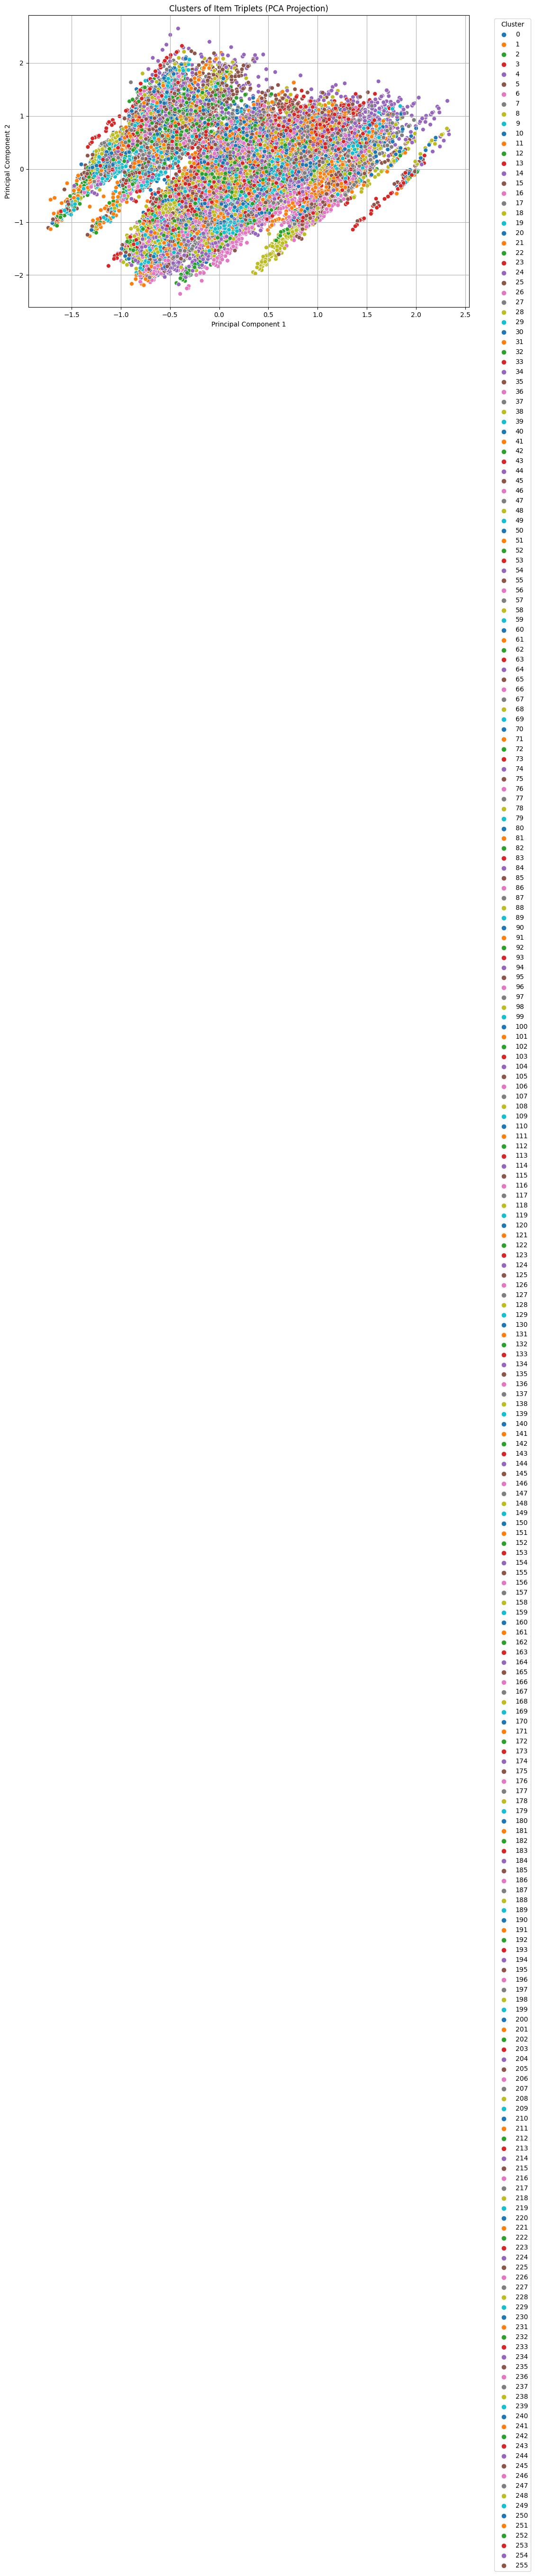

In [45]:
# Convert X_vectors (list of np.arrays) into a 2D array
X_array = np.vstack(X)

# Get cluster labels
cluster_ids = kmeans.labels_

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_array)

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_ids, palette='tab10', s=40)
plt.title("Clusters of Item Triplets (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5 || Final Tests and Submission

## 5.1 || Application Testing Simulation

In [49]:
def test_recommender_interactive(
    default_store=2156,
    default_cust_type="Registered",
    default_item1="6 pc Grilled Wings Combo",
    default_item2="20 pc Grilled Wings",
    default_item3="20pc Spicy Feast Deal"
):
    print("<===== Wings R Us Recommender Test =====>")

    try:
        # # Prompt with defaults
        # store_input = input(f"Enter STORE_NUMBER [{default_store}]: ").strip()
        # cust_type_input = input(f"Enter CUSTOMER_TYPE [{default_cust_type}]: ").strip()
        # item1_input = input(f"Enter item1 name [{default_item1}]: ").strip()
        # item2_input = input(f"Enter item2 name [{default_item2}]: ").strip()
        # item3_input = input(f"Enter item3 name [{default_item3}]: ").strip()
        
        # store = int(store_input) if store_input else default_store
        # cust_type = cust_type_input if cust_type_input else default_cust_type
        # item1 = item1_input if item1_input else default_item1
        # item2 = item2_input if item2_input else default_item2
        # item3 = item3_input if item3_input else default_item3
        store = default_store
        cust_type = default_cust_type
        item1 = default_item1
        item2 = default_item2
        item3 = default_item3

        # Encode items
        item_inputs = []
        for item in [item1, item2, item3]:
            if item not in item2id:
                print(f"⚠️ Item '{item}' not found in item2id. Recommendation may be less accurate.")
            item_inputs.append(item2id.get(item, None))

        if None in item_inputs:
            print("❌ One or more items not recognized. Please try with known items.")
            return

        # Get recommendations
        encoded_recs = get_recommendations(store, cust_type, *item_inputs)
        decoded_recs = [id2item.get(i, "UNKNOWN") for i in encoded_recs]

        # Output
        print("\n✅ Recommended items:")
        for idx, item in enumerate(decoded_recs, 1):
            print(f"  {idx}. {item}")

    except Exception as e:
        print(f"❌ Error: {e}")
        
test_recommender_interactive()

<===== Wings R Us Recommender Test =====>

✅ Recommended items:
  1. Ranch Dip - Regular
  2. Regular Buffalo Fries
  3. Ranch Dip - Large


## 5.2 || Creating Submission File

In [52]:
submission_rows = []

# Build submission rows from test_df
for idx, row in tqdm(test_data.iterrows(), total=len(test_data)):
    store = row['STORE_NUMBER']
    cust_type = row['CUSTOMER_TYPE']
    
    input_items = [row['item1'], row['item2'], row['item3']]
    encoded_items = [item2id.get(item) for item in input_items]

    if None in encoded_items:
        continue  # Skip unknown items

    sorted_encoded = sorted(encoded_items)
    recs_encoded = get_recommendations(store, cust_type, *sorted_encoded)
    recs_decoded = [id2item.get(i, "UNKNOWN") for i in recs_encoded]

    while len(recs_decoded) < 3:
        recs_decoded.append("")

    submission_rows.append({
        "CUSTOMER_ID": row["CUSTOMER_ID"],
        "ORDER_ID": row["ORDER_ID"],
        "item1": input_items[0],
        "item2": input_items[1],
        "item3": input_items[2],
        "item4": "Missing",
        "RECOMMENDATION 1": recs_decoded[0],
        "RECOMMENDATION 2": recs_decoded[1],
        "RECOMMENDATION 3": recs_decoded[2]
    })

# Convert to DataFrame
submission_df = pd.DataFrame(submission_rows)

# Save to CSV
team_name = "Gods"  # Replace with actual team name
output_filename = f"{team_name}_Recommendation_Output_Sheet.csv"
submission_df.to_csv(f"output_filename", index=False)
submission_df.head()

100%|██████████| 1000/1000 [00:00<00:00, 4950.60it/s]


,CUSTOMER_ID,ORDER_ID,item1,item2,item3,item4,RECOMMENDATION 1,RECOMMENDATION 2,RECOMMENDATION 3
0,997177535,9351345556,Chicken Sub Combo,Ranch Dip - Regular,10 pc Spicy Wings Combo,Missing,6 pc Spicy Wings Combo,10 pc Spicy Wings,10 pc Grilled Wings Combo
1,345593831,3595377080,Regular Buffalo Fries,10 pc Spicy Wings,3 pc Crispy Strips Combo,Missing,Ranch Dip - Regular,10 pc Grilled Wings,Cheese Dip - Regular
2,160955031,4071757785,Large Buffalo Fries,10 pc Spicy Wings,Ranch Dip - Regular,Missing,3 pc Crispy Strips Combo,Blue Cheese Dip - Regular,10 pc Grilled Wings
3,890671991,3931766769,6 pc Grilled Wings Combo,20 pc Grilled Wings,Fried Corn - Large,Missing,Ranch Dip - Large,20 pc Mixed Wings,Ranch Dip - Regular
4,73989021,3739700809,Regular Buffalo Fries,20 pc Grilled Wings,Ranch Dip - Large,Missing,Add 5 Grilled Wings,Veggie Sticks Spicy,20pc Spicy Feast Deal


## 5.3 || Test for Invalid Entries

In [56]:
invalid_values = {"", None, "NOT_FOUND", "UNKNOWN", -1}

for col in submission_df.columns:
    if "RECOMMENDATION" in col:
        print(f"Checking column: {col}")
        
        # Show value counts
        counts = submission_df[col].value_counts(dropna=False)
        display(counts.sort_index())

        # Check for invalid entries
        invalid_entries = submission_df[col].isin(invalid_values)
        num_invalid = invalid_entries.sum()

        if num_invalid > 0:
            print(f"⚠️ Found {num_invalid} invalid entries in {col}")
        else:
            print("✅ All entries are valid.\n")

Checking column: RECOMMENDATION 1


RECOMMENDATION 1
10 pc Grilled Wings          41
10 pc Grilled Wings Combo    40
10 pc Mixed Wings             1
10 pc Mixed Wings Combo       1
10 pc Spicy Wings            38
                             ..
Triple Chocolate Cake         4
Veggie Sticks                 3
Veggie Sticks Spicy          12
Voodoo Fries - Large          5
Voodoo Fries - Regular        7
Name: count, Length: 68, dtype: int64

✅ All entries are valid.

Checking column: RECOMMENDATION 2


RECOMMENDATION 2
10 pc Grilled Wings          42
10 pc Grilled Wings Combo    48
10 pc Mixed Wings             1
10 pc Spicy Wings            33
10 pc Spicy Wings Combo      12
                             ..
Triple Chocolate Cake         1
Veggie Sticks                 3
Veggie Sticks Spicy          20
Voodoo Fries - Large          1
Voodoo Fries - Regular       11
Name: count, Length: 74, dtype: int64

✅ All entries are valid.

Checking column: RECOMMENDATION 3


RECOMMENDATION 3
10 pc Grilled Wings          53
10 pc Grilled Wings Combo    33
10 pc Mixed Wings Combo       4
10 pc Spicy Wings            27
10 pc Spicy Wings Combo      11
                             ..
Triple Chocolate Cake         1
Veggie Sticks                10
Veggie Sticks Spicy          13
Voodoo Fries - Large          3
Voodoo Fries - Regular        5
Name: count, Length: 71, dtype: int64

✅ All entries are valid.

